# CP Asymmetry in Three Body Decays

## Example program

Supervisors: Keri Vos, Joan Ruiz Vidal, Marta Burgos

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Input data
This opens input data files and assigns them to variables.

In [3]:
path = '/Users/student/Desktop/b_decay_files/' # set this to the repository location in your laptop
events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
events_down = uproot.open(path+'B2HHH_MagnetDown.root')
events_up = uproot.open(path+'B2HHH_MagnetUp.root')

### Select data
The following cell reads the input data. This is where selection criteria are applied (such as the z component of the momentum being positive).

In [5]:
typedata=input('Select type of data: Simulation = 1 ; Magnet Up data = 2 ; Magnet Down data= 3 ; Magnet Up + Down data = 4 : ')
typedata=int(typedata)

numevents=input('Maximum number of events (to run over all the events: -1) : ')
numevents=int(numevents)

# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())
print('Type data', typedata)

# These are the arrays to hold the data

ptot1= [] #Arrays to hod momentum vectors for the three decay products
ptot2= []
ptot3= []

pTot_H1=[] #Arrays of momentum vectors after the cuts are applied
pTot_H2=[]
pTot_H3=[]
pZ_H1=[]


# Here goes the masses of the particles

mK = 493.68
mPi = 139.6

# Other variables

count = 0

mass_12p = [] #invariant mass of one pair
mass_23p = []
mass_13p = []
mass_Bp = [] #reconstructed mass of the B meson

mass_12m = [] #invariant mass of one pair
mass_23m = []
mass_13m = []
mass_Bm = [] #reconstructed mass of the B meson

mass_n1 = 0.0
mass_n2 = 0.0
m_low =[]
m_high =[]

Ei_H1 = 0.0 # placeholder energy value of kaon per event
Ei_H2 = 0.0
Ei_H3 = 0.0

P_12 = [] # array to hold total momenta of kaons
P_23 = []
P_13 = []
P_123 = []

dP_1 =[]
dP_2 =[]
dP_3 =[]

E_H1 = [] # array to hold energies of kaons
E_H2 = []
E_H3 = []

M123 =0.0
M12 = 0.0
M23 = 0.0
M13 = 0.0

# A counter for bookkeeping
event_counter = 0
nevents = 0

# If set to a value greater than 0, limits the number of events analysed
# Set to -1 to run over all events. 
# It is recommended to keep the number of events limited while developing the analysis.
MAX_EVENTS = numevents

# Select the data that will be analyzed

if typedata==1: trees=[events_sim['PhaseSpaceTree']]   # Simulation
if typedata==2: trees=[events_up['DecayTree']]         # Magnet up data
if typedata==3: trees=[events_down['DecayTree']]     # Magnet down data
if typedata==4: trees=[events_down['DecayTree'],events_up['DecayTree']] # Magnet down+up data

# This loop goes over the trees to be analysed
for tree in trees:
    # This outer loop is a technical loop of uproot over chunks of events
    for data in tree.iterate(filter_name=['H*_P[XYZ]','H*_Charge','H*_Prob*','H*_isMuon']):
        # As Python can handle calculations with arrays, we can calculate derived quantities here
        
        ptot1 = np.sqrt(data['H1_PX']**2+data['H1_PY']**2+data['H1_PZ']**2)
        ptot2 = np.sqrt(data['H2_PX']**2+data['H2_PY']**2+data['H2_PZ']**2)
        ptot3 = np.sqrt(data['H3_PX']**2+data['H3_PY']**2+data['H3_PZ']**2)
        
        # This loop will go over individual events
        
        for i in range(0,len(data['H1_PZ'])):
            event_counter += 1
         
            if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
            if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
                
            # Definition of variables:



            
            # Decide here which events to analyse
            if (data['H1_PZ'][i] < 0) or (data['H2_PZ'][i] < 0) or (data['H3_PZ'][i] < 0): continue
            if (data['H1_ProbK'][i] < 0.6) or (data['H2_ProbK'][i] < 0.6) or (data['H3_ProbK'][i] < 0.6): continue
            if (data['H1_isMuon'][i] == 1) or (data['H2_isMuon'][i] == 1) or (data['H3_isMuon'][i] == 1): continue
            
            #calculate energy for these particles individually
            Ei_H1 = (data['H1_PX'][i]**2+data['H1_PY'][i]**2+data['H1_PZ'][i]**2+mK**2)**0.5
            Ei_H2 = (data['H2_PX'][i]**2+data['H2_PY'][i]**2+data['H2_PZ'][i]**2+mK**2)**0.5
            Ei_H3 = (data['H3_PX'][i]**2+data['H3_PY'][i]**2+data['H3_PZ'][i]**2+mK**2)**0.5
            
            #calculate impulse for all particle pairs
            P_12 = [data['H1_PX'][i]+data['H2_PX'][i], data['H1_PY'][i]+data['H2_PY'][i], data['H1_PZ'][i]+data['H2_PZ'][i]]
            P_23 = [data['H2_PX'][i]+data['H3_PX'][i], data['H2_PY'][i]+data['H3_PY'][i], data['H2_PZ'][i]+data['H3_PZ'][i]]
            P_13 = [data['H1_PX'][i]+data['H3_PX'][i], data['H1_PY'][i]+data['H3_PY'][i], data['H1_PZ'][i]+data['H3_PZ'][i]]
            P_123 = [data['H1_PX'][i]+data['H2_PX'][i]+data['H3_PX'][i], data['H1_PY'][i]+data['H2_PY'][i]+data['H3_PY'][i], data['H1_PZ'][i]+data['H2_PZ'][i]+data['H3_PZ'][i]]
            
            #caculate mass of all particle pairs
            M12 = ((Ei_H1 + Ei_H2)**2 - np.linalg.norm(P_12)**2)**0.5
            M13 = ((Ei_H1 + Ei_H3)**2 - np.linalg.norm(P_13)**2)**0.5
            M23 = ((Ei_H2 + Ei_H3)**2 - np.linalg.norm(P_23)**2)**0.5
            M123 = ((Ei_H1 + Ei_H2 + Ei_H3)**2 - np.linalg.norm(P_123)**2)**0.5
            
           #cut data for B-meson mass
            #if (M123 < 5252) or (M123 > 5315): continue


            #save masses of both neutral particle pairs
            if (data['H1_Charge'][i] + data['H2_Charge'][i] == 0):         
                mass_n1 = M12
                if (data['H1_Charge'][i] + data['H3_Charge'][i] == 0):
                    mass_n2 = M13
                else: mass_n2 = M23
            else: 
                mass_n1 = M13
                mass_n2 = M23

            #save B-meson data
            if(data['H1_Charge'][i] + data['H2_Charge'][i] + data['H3_Charge'][i] > 0):
                mass_Bp.append(M123)
            else: mass_Bm.append(M123)
            
            #save all the data in arrays
            if (mass_n1 < mass_n2):                                        
                m_low.append(mass_n1)
                m_high.append(mass_n2)
            else:
                m_low.append(mass_n2)
                m_high.append(mass_n1)
                
            E_H1.append(Ei_H1)
            E_H2.append(Ei_H2)
            E_H3.append(Ei_H3)
            
            pTot_H1.append(ptot1[i])
            pTot_H2.append(ptot2[i])
            pTot_H3.append(ptot3[i])
            
            
            nevents+=1
      
                
print('Read {:d} events'.format(event_counter))
print(nevents)



Input data variables:
['B_FlightDistance', 'B_VertexChi2', 'H1_PX', 'H1_PY', 'H1_PZ', 'H1_ProbK', 'H1_ProbPi', 'H1_Charge', 'H1_IPChi2', 'H1_isMuon', 'H2_PX', 'H2_PY', 'H2_PZ', 'H2_ProbK', 'H2_ProbPi', 'H2_Charge', 'H2_IPChi2', 'H2_isMuon', 'H3_PX', 'H3_PY', 'H3_PZ', 'H3_ProbK', 'H3_ProbPi', 'H3_Charge', 'H3_IPChi2', 'H3_isMuon']
Type data 4
Read 100000 events
Read 200000 events
Read 300000 events
Read 400000 events
Read 500000 events
Read 600000 events
Read 700000 events
Read 800000 events
Read 900000 events
Read 1000000 events
Read 1100000 events
Read 1200000 events
Read 1300000 events
Read 1400000 events
Read 1500000 events
Read 1600000 events
Read 1700000 events
Read 1800000 events
Read 1900000 events
Read 2000000 events
Read 2100000 events
Read 2200000 events
Read 2300000 events
Read 2400000 events
Read 2500000 events
Read 2600000 events
Read 2700000 events
Read 2800000 events
Read 2900000 events
Read 3000000 events
Read 3100000 events
Read 3200000 events
Read 3300000 events
Read 

Plotting B mass


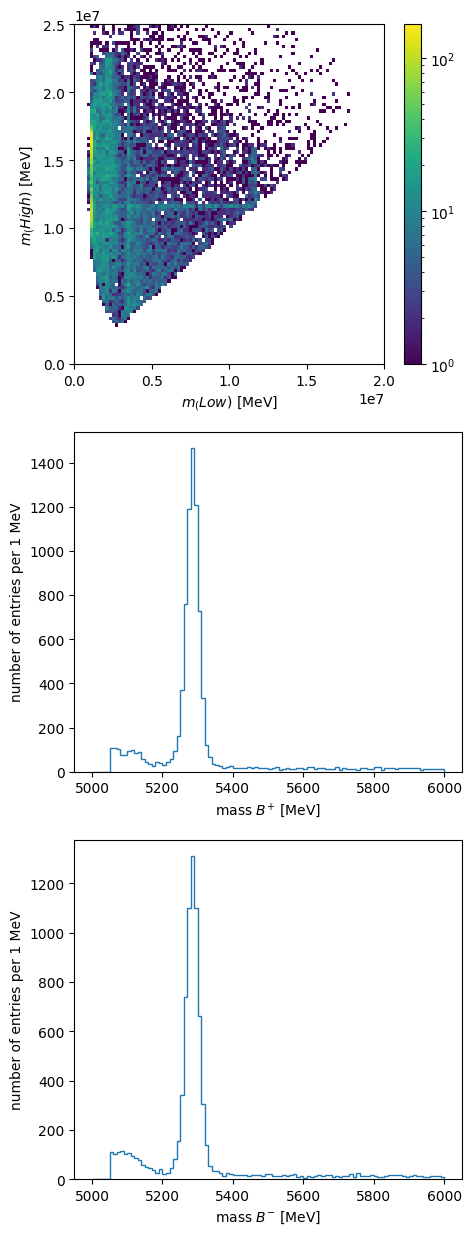

In [107]:
fig, ax = plt.subplots(nrows=3, figsize=[5,15])


# This plots a 1D-histogram.
# The color is changed automatically, the styles are set by hand
print('Plotting B mass')
#values_pTot_H1,bins_pTot_H1,patches_pTot_H1 = ax.hist(mass_12, bins = 100, range = [5.2*(10**3), 5.4*(10**3)],histtype='step',label='$p_{H1}^{\\text{Tot}}$')
#ax.set_ylabel('Entries per 2 GeV')
#ax.legend('Total momentum of Hadron 1 [MeV]')
# plt.savefig('pTot_H1.pdf')
nbins = 100
massrange =  [5*(10**3),6*(10**3)]
binwidth = (massrange[1]-massrange[0])/nbins

dalitz = ax[0].hist2d(np.square(m_low), np.square(m_high), bins= [nbins,nbins], range = [[0, 20*(10**6)], [0, 25*(10**6)]], norm = colors.LogNorm(), cmap='viridis')
fig.colorbar(dalitz[3])

ax[0].set_xlabel(r'$m_(Low)$ [MeV]')
ax[0].set_ylabel(r'$m_(High)$ [MeV]')

nmass_Bp, binsmass_Bp, patchesp = ax[1].hist(mass_Bp, bins = nbins, range = massrange, histtype='step')
# nmass_Bp is the height of the histogram per bin
# binsmass_Bp is the divisions between bins

ax[1].set_xlabel(r'mass $B^{+}$ [MeV]')
ax[1].set_ylabel(r'number of entries per 1 MeV')


nmass_Bm, binsmass_Bm, patchesm = ax[2].hist(mass_Bm, bins = nbins, range = massrange, histtype='step')
ax[2].set_xlabel(r'mass $B^{-}$ [MeV]')
ax[2].set_ylabel(r'number of entries per 1 MeV')


#ratio = []
#ratio.append(np.ones(len(mass_Bp)) *  1)
#ratio.append(np.ones(len(mass_Bm)) * -1)

#ax[3].hist(ratio, bins = 2, histtype='stepfilled')
#ax[3].set_xlabel('charge type of B-meson')
#ratioscal = len(mass_Bp)/len(mass_Bm)
#print(len(mass_Bp), 'Bp /', len(mass_Bm), 'Bm')
#print(nmass_Bp)


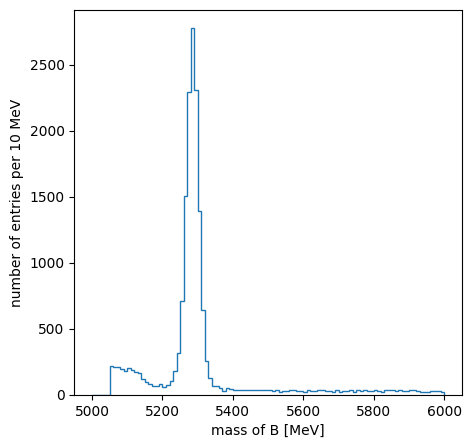

In [106]:
fig, ax = plt.subplots(figsize=[5,5])
mass_B, binsmass_B, patchesB = ax.hist(np.append(mass_Bm,mass_Bp), bins = nbins, range = massrange, histtype='step')
ax.set_xlabel(r'mass of B [MeV]')
ax.set_ylabel(r'number of entries per 10 MeV')
plt.savefig("B_mass_peak.pdf")

## Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

[-5.16362000e-02  3.12784919e+02  5.28476598e+03  1.39326648e+03
  1.72433642e+01]
22
[-4.80544864e-02  2.88868389e+02  5.28445393e+03  1.26095833e+03
  1.76627588e+01]
22
Fit results with chi2/ndf 44.67026160573834 / 22
Par 1: -0.051636 +/- 0.063691
Par 2: 312.784919 +/- 333.923473
Par 3: 5284.765978 +/- 0.179120
Par 4: 1393.266481 +/- 12.861487
Par 5: 17.243364 +/- 0.200341
Fit results with chi2/ndf 39.22839268389235 / 22
Par 1: -0.048054 +/- 0.051275
Par 2: 288.868389 +/- 268.803044
Par 3: 5284.453934 +/- 0.161098
Par 4: 1260.958327 +/- 10.221573
Par 5: 17.662759 +/- 0.180742


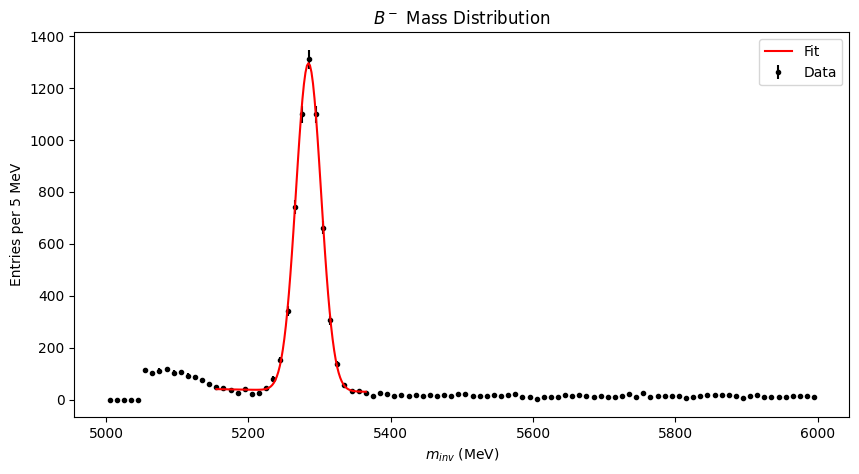

In [127]:
# decaying exponential function
def exponential(x, mean, ampE, stdev):
    xoffset = 0 # this is a technical parameter, which can be used to move the position at which the function evaluates to "norm"
    return np.array(ampE * np.exp(-((x-mean)/stdev)**2/2))

# constant function
def background(x, bg_coeff, constval):
    return np.array(bg_coeff * x + constval)

# fit function combining two individual functions
def fit_function(x, bg_coeff, constval, mean, ampE, stdev):
    return background(x, bg_coeff, constval) + exponential(x, mean, ampE, stdev)

    #return np.array(background(x, bg_coeff, constval) + exponential(x, mean, ampE, stdev) )

def fit_data(bins, values, minX, maxX, p0):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays

    # reduce range to fit only part of curve
    bin_centres_red = [] 
    values_red = []
    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: continue
        bin_centres_red.append(c)
        values_red.append(v)

    # execute the fit with starting values as given in p0
    coeff_fit, cov_fit = curve_fit(fit_function,bin_centres_red,values_red, p0) # fit
    print(coeff_fit)
    
    # evaluate chi2
    fit_vals = [fit_function(x, coeff_fit[0], coeff_fit[1], coeff_fit[2], coeff_fit[3], coeff_fit[4]) for x in bin_centres_red]
    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ), 
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    chi2 = np.sum( chi2parts )
    print(len(bin_centres_red))
    return coeff_fit,cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

# the calculations are up to this point

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covariance matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

def plot_results(ax,bin_centres,bin_centres_red,values,coeff_fit,fname, title, name):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    ax.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0], coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4])
    ax.plot(x_fit,y_fit, label= name, color='r',zorder=10) # zorder makes sure the fit line is on top

    # plot decoration
    ax.legend()
    ax.set_xlabel('$m_{inv}$ (MeV)')
    ax.set_ylabel('Entries per 5 MeV')
    plt.title(title)
    #plt.savefig(fname)



mB = 5279.41 #mean peak value
    #linea  lineb mean ampE stdev
p0p = [-0.2, 10.0, mB, 700.0, 50.0] # best guess

range_fit = [5.15*(10**3), 5.37*(10**3)]
xpData = binsmass_Bp
ypData = nmass_Bp

p0m = p0p #[-0.2, 10.0, mB, 40.0, 50.0] # best guess

xmData = binsmass_Bm
ymData = nmass_Bm


coeff_mBp, cov_mBp, bin_centres_mBp, bin_centres_red_mBp, chi2_mBp, ndf_mBp = fit_data(xpData, ypData, range_fit[0], range_fit[1], p0p )
coeff_mBm, cov_mBm, bin_centres_mBm, bin_centres_red_mBm, chi2_mBm, ndf_mBm = fit_data(xmData, ymData, range_fit[0], range_fit[1], p0m )

print_results(coeff_mBp,cov_mBp, chi2_mBp, ndf_mBp)
print_results(coeff_mBm,cov_mBm, chi2_mBm, ndf_mBm)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
#plot_results(ax,bin_centres_mBp,bin_centres_red_mBp,ypData,coeff_mBp,'fit_mBp.pdf', r"$B^{+}$ Mass Distribution", "Fit")
plot_results(ax,bin_centres_mBm,bin_centres_red_mBm,ymData,coeff_mBm,'fit_mBm.pdf', r"$B^-$ Mass Distribution", "Fit")
plt.savefig("best_fit_minus.pdf")


## Gaussian Integral
Calculating the total number of events and finding the CP asymmetry

In [128]:
import math

def func (x, mean, ampE, stdev):
   return ampE * np.exp(-((x-mean)/stdev)**2/2)

result_p = coeff_mBp[3] * coeff_mBp[4] * np.sqrt(2*np.pi)
result_m = coeff_mBm[3] * coeff_mBm[4] * np.sqrt(2*np.pi)

print("Integration Result B+:", result_p/binwidth)
print("Integration Result B-:", result_m/binwidth)

asymmetry = (result_m-result_p)/(result_m+result_p)
print("A_CP =", asymmetry)


param_err_p = np.sqrt(np.diag(cov_mBp))
param_err_m = np.sqrt(np.diag(cov_mBm))

events_p_err = np.sqrt(2 * math.pi * (coeff_mBp[4]**2 * param_err_p[3]**2 + coeff_mBp[3]**2 * param_err_p[4]**2))
events_m_err = np.sqrt(2 * math.pi * (coeff_mBm[4]**2 * param_err_m[3]**2 + coeff_mBm[3]**2 * param_err_m[4]**2))

print(events_p_err)
print(events_m_err)
error_cp = np.sqrt((events_p_err * -2*result_m/(result_m+result_p)**2)**2 + (events_m_err * 2*result_p/(result_m+result_p)**2)**2)
print("A_CP error =", error_cp)

Integration Result B+: 6022.074500792439
Integration Result B-: 5582.763204224087
A_CP = -0.0378558759489111
893.6298989763736
728.8082466393339
A_CP error = 0.009867967634057891
